# Power

As we saw in the lecture, the concepts of specificity and sensitivity/power are concerned with controlling the rate of type I and type II errors respectively, where type I errors are false positives and type II errors are false negatives.

<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/t1t2_error.png" width=80% >

Think about it this way:
* When we are talking about specificity (controlling type I errors) we are proposing that the true population effect is zero (say, correlation and we are interested in the probability of obtaining a certain value of a test statstistic (say, correlation r=0.25) due to chance.
* When we are talking about power (controlling type II errors) we are proposing that the true populaiton effect is non-zero (say correlation and we are interested in how frequently we fail to reject the null hypothesis.

In this notebook we see how we can work out the power (or probability of detecting a true effect if there is one) for a given effect size.

We will work with correlation (Pearson's $r$), although later we will see that the same approach can be used for difference of means/ the $t$-test.


### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [4]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Power of a Correlation

I collect data on end-ofyear exam scores in Maths and French for 50 high school studehts. Then I calculate the correlation coefficient, Pearson's r, between Maths and French scores across my sample of 50 participants.

* $\mathcal{H_0}$ Under the null hypothesis there is no correlation between maths scores and French scores
* $\mathcal{H_a}$ Under the alternative hypothesis, there is a correlation

I observe a correlation of r=0.25 (this is my *effect size*)

Can I trust this result? 

### Eyeballing the data

What does a correlation of 0.25 look like for 50 data points?
Here are some examples of datasets that actually have r=0.25:

<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/images/r25_examples.png" width=100% >

**Would you trust those correlations?**

## Simulating the population

* A type I error (false positive) occurs when we get a significant correlation in a sample, even though there is no true correlation in the population

* A type II error (false negative) occurs when we *fail to get* a significant correlation in a sample, even though there is a true correlation in the population

To understand the relationship between these two types of error, we are going to generate two 'populations' of data

* A 'null population' where the true correlation $\rho=0$
* A 'correlated population' where the true correlation $\rho=0.25$

Each dataset will have 25000 pairs in it (so 2 columns, 25000 rows), with a correlation between columns of zero (null population) or 0.25 (correlated population). 

By drawing random samples of size 50 from each, we can ask:

* how often do we find a significant correlation when drawing from the null population (false positive, Type I error)?
* how often do we *fail to find* a significant correlation when drawing from the correlated population (false negative, Type II error)?


**You will not be asked to replicate this code so don't worry about the details**

## Null population

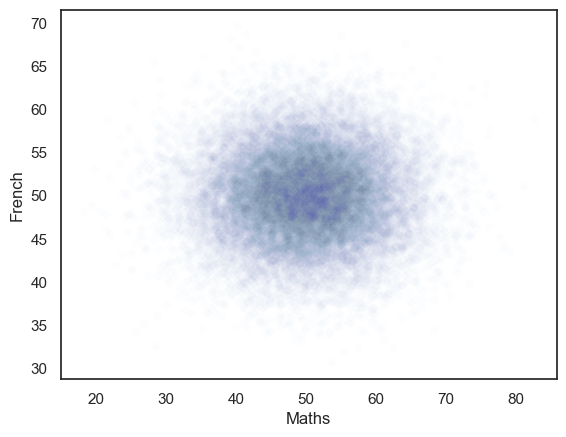

In [8]:
# Code to generate the population with zero correlation - don't worry about understanding this bit

rho=0 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=50
s0=8
s1=5

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rZero=pd.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rZero,x='Maths',y='French',alpha=0.01)
plt.show()

The generated dataset has two columns and 25,000 rows. 

The correlation between the two columns should be close to the <tt>r</tt> value we set, ie zero. 

The scatterplot definitely looks like there is no correlation!

In [9]:
# check that the actual correlation is in the 10000 simulated samples
pop_rZero.corr()

,Maths,French
Maths,1.000000,0.005562
French,0.005562,1.000000


### $p$ by simulation

We can now work out how often we get a significant correlation ($p<0.05$) in samples ($n=50$) drawn from the null population, by drawing 10000 samples and getting the p value for each one using `stats.pearsonr().pvalue`.

The number of false positives will simply be the proportion of those obtained $p$-values that are below 5%.

In [10]:
nReps=10000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.0502

Hopefully the proportion of samples from the no-correlation distribution with p<0.05 is about.... 0.05. 

## Correlated population

Now we generate a population with a true correlation of $r=0.25$

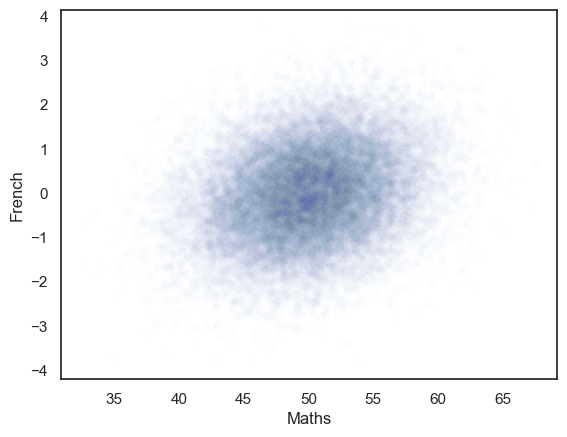

In [13]:
# Code to generate the population with a correlation of rho - don't worry about understanding this bit

rho=0.25 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=0
s0=4.5
s1=1

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rNonZero=pd.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rNonZero,x='Maths',y='French',alpha=0.01)
plt.show()


We can check the correlation in the full population of 25000 samples, hopefully this should be close to 0.25.

In [23]:
pop_rNonZero.corr()

,Maths,French
Maths,1.000000,0.256304
French,0.256304,1.000000


### Power by simulation

We can investigate power in our correlation example using the same simulation approach as above, but now we need to *assume the true population correlation $\rho$ is 0.25*

The question for our *power analysis* is, for samples of size n=50, what proportion of the time will I obtain a significant correlation (reject the null)?

To answer that question I am going to draw samples of size 50 from the population *which actually has $r$=0.25* and obtain the sample correlation for each of those samples and its p value using `stats.pearsonr().pvalue`. 

I can then ask in what proportion of simulated samples $p<0.05$, ie in what proportion of the simulated samples we manage to reject the null.

In [24]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.423

In my simulation I manage to reject the null in about 41% of simulations (note the exact value you get will vary slightly each time you run the simulation). So my test has a power of 41%


<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/images/Minion_what.jpg" width=15% >

Yes, that's right. In a population where the *true* correlation between two variables (scores on Maths and French tests) is 0.25, for samples of size 50, I will fail to detect a significant correlation (ie, I will make a Type 2 error) over half the time.

This would be true for any data with a true correlation of 0.25 and sample size of 50 - $n$=50 is really not enough to detect a weakish correlation.

Try changing $n$ in the code block below to be smaller (eg $n$=25) or larger ($n$=150) and see what happens to the power.

In [25]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.436

## Finding the required sample size

We have just seen that a large sample size is needed to get good power for a weak correlation. In general, the power of a test (1 - chance of a Type 2 error) increases with $n$ whilst the specificity (1 - chance of a type 1 error) does not. Why?

#### The probability of a Type 1 error does not depend on sample size

Statistical tests are designed to control the probability of a type 1 error. When calculating the critical value of the test statistic (in the case of correlation, the test statistic is $r$ and the critical value is minimum $r$ value that would be considered significant for a given sample size $n$, $n$ is directly taken into account. Therefore, the probably of a type 1 error is fixed regardless of sample size.

#### The probability of a Type 2 error *does* depend on sample size

The above is *not* true for type 2 error. The probability of Type 2 error (and hence the power of the test) varies with sample size.

If we increase the sample size, the power of the test increases.

Let's try it! Change the sample size in the code block below to 10,100 and 1000. How does the power change


In [26]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
    
# How many of our 10000 samples had p<0.05?
print('power = ' + str(100*(np.mean(p<0.05))) + '%')

power = 42.0%


We can loop over different sample sizes and plot how power increases as sample size increases:

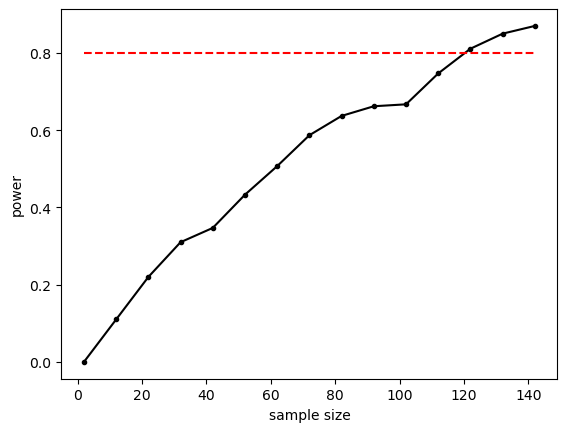

In [62]:
n=range(2,150,10)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=1000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
    
    power[s]=np.mean(p<0.05)
    
# plot the results
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.show()

The relationship between sample size and power is slightly bumpy as we checked only 1000 simulated samples at each sample size. If you increased nReps to 10,000 the curve would look smoother (but the simulation ould take a long time to run).

Conventionally a power of 80% (indicated by the red dashed line on the graph) is considered desirable. What sample size do we need to get power of 80%? It looks from the graph like you would need around n=120. Let's re-run a finer grained simulation in that range:



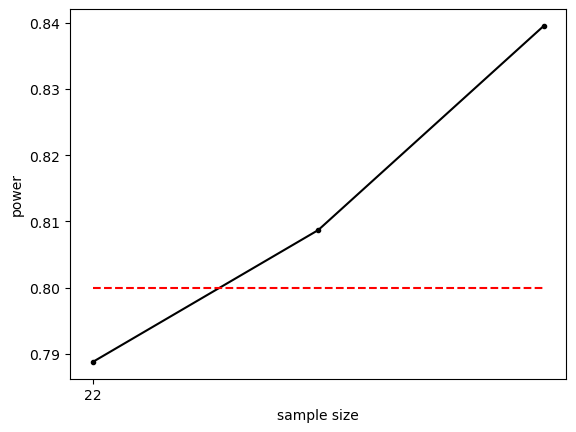

In [60]:
n=range(115,125)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=10000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French']).pvalue
    
    power[s]=np.mean(p<0.05)
    
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.xticks(range(min(n),max(n),5))
plt.show()

## Built in function for power

There is a built in function in a package called `statsmodels` for doing power analysis.

You can use it to find the power for a given sample size:

In [41]:
# import required modules
from statsmodels.stats.power import TTestIndPower
    
# perform power analysis to find sample size 
# run the power analysis relating alpha, d, n1, n2 
analysis = TTestIndPower()

# solve for sample size
power = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=8, ratio=12/8, power=None, alternative='larger')
    
print('power = ' + str(power*100) + '%')

power = 48.29582456481827%


This is hopefully not a bad match to our homemade code above (it won't be a perfect match as our homemade one is based on random sampling)

Instead of calculating the power for a given sample size, we can calculate the sample size required to achieve a given power (say 80%). As our samples are independent and have different sizes, we assumme the ratio is fixed (12 psychology students to 8 geography, or 120 psychology to 80 geography):

In [42]:
# solve for sample size
n1 = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=None, ratio=12/8, power=0.8, alternative='larger')
  
print('required sample size: n1 = ' + str(n1) + '; n2 = ' + str(n1*12/8))

required sample size: n1 = 18.405740901828487; n2 = 27.60861135274273


/Users/joreilly/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


The syntax for the power analysis is a bit fiddly so let's recap it:

There is a four way relationship between:
  * sample size(s) (`nobs`)
  * alpha values (`alpha`)
  * effect size (`effect size`)
  * power

If we know three of them, we can work out the fourth.

... note that we specify the samples size thus:
   * size of group 1 is `nobs`
   * `ratio` tells us the ratio n2/n1
   
#### Running it   

When we run power analysis using `TTestIndPower` we first run an analysis that models the relationship between the four factors for the test in question (independent samples t-test in this case, but it could have been a paired t-test, or something else that we haven'e met yet like an ANOVA or Chi Square test):

In [43]:
analysis = TTestIndPower()

Then we solve the equations, giving the computer three out of the four values and setting the fourth to `None`:

In [44]:
# solve for power
power = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=8, ratio=12/8, power=None, alternative='larger')
print('power = ' + str(power*100) + '%')

# solve for sample size
n1 = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=None, ratio=12/8, power=0.8, alternative='larger')
print('required sample size: n1 = ' + str(n1) + '; n2 = ' + str(n1*12/8))

# what alpha value would you need to use to have a power of 80% with the sammple sizes 8,12?
# solve for sample size
alpha = analysis.solve_power(effect_size=0.760, alpha=None, nobs1=8, ratio=12/8, power=0.8, alternative='larger')
print('required alpha = ' + str(alpha))

power = 48.29582456481827%
required sample size: n1 = 18.405740901828487; n2 = 27.60861135274273
required alpha = 0.20952367203411126


### Note on effect size

In this case we worked out the effect size in our actual sample of 12 psychologists and 8 geographers, as 0.760, and conducted a power analysis using that effect size. This is sometimes called a post-hoc power analysis. It told us that we should have tested 19 and 28 people rather than 12 and 8. This isn't quite the intended purpose of poewr analysis (to work out the required sample size in advance) but is how power analysis is often used in reality - to evaluate post hoc, or after the fact, whether a study was sufficiently well powered.

# Paired sample t-test

There is a version of the power analysis for paired samples t-test (indeed, there are versions for various analyses, although not for correlation annoyingly).

The version for paired samples t-test is called `TTestPower()` as opposed to `TTestIndPower`

See if you can work out how to use this to find the sample size required for 80% power for an effect size of $d=0.5$, testing at $\alpha$=0.05.

In [45]:
# import required modules
from statsmodels.stats.power import TTestPower

# run an analysis that models the relationship between the four factors 
analysis = # your code here

# solve for n
# your code here

SyntaxError: invalid syntax (1682179668.py, line 5)

#### another example 

... think back to how we calculated d, see if you can run one from the raw data. 

Let's look at the brother-sister heights data.

In [46]:
heights=pandas.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/data/BrotherSisterData.csv')
heights

,brother,sister
0,174,172
1,183,180
2,154,148
3,172,180
4,172,165
5,161,159
6,167,159
7,172,164
8,195,188
9,189,175


conduct a paired t-test to see if brothers are taller than sisters - it's highly significant

In [47]:
stats.ttest_rel(heights['brother'],heights['sister'])

TtestResult(statistic=5.742269354639271, pvalue=6.442462549436049e-06, df=24)

We need to calculate $d$ as:

$$ d = \frac{\overline{x_b-x_s}}{s} $$

where:
* $\overline{x_b-x_s}$ is the mean height difference for (brother-sister)
* $s$ is the standard deviation of the differences


In [ ]:
# your code here

The we can run the power model for the paired test, and solve for power:

In [ ]:
# import required modules
from statsmodels.stats.power import TTestPower

# run an analysis that models the relationship between the four factors 
analysis = # your code here


# solve for power
# your code here

In [68]:

# import required modules
from statsmodels.stats.power import TTestPower

# run an analysis that models the relationship between the four factors 
analysis = TTestPower()

# solve for sample size
n1 = analysis.solve_power(effect_size=0.4, alpha=0.05, nobs=24, power=None, alternative='larger')
print('required sample size: n1 = ' + str(n1))

# solve for power
# your code here

required sample size: n1 = 0.6012625837815468


In [69]:
5/8


0.625